# Multi-modal Search on the Amazon Reviews Dataset


## Introduction

The [_Amazon Product Dataset_](http://jmcauley.ucsd.edu/data/amazon/links.html) contains product metadata, reviews, and image feature vectors for 9.4 million Amazon products. The dataset was collected by researchers at UCSB. For more information, see the paper _Justifying recommendations using distantly-labeled reviews and fined-grained aspects_ by Jianmo Ni, Jiacheng Li, and Julian McAuley. 

In this tutorial, we'll use the metadata and image feature vectors from the clothing, shoes, and jewelry category to demonstrate how Elastiknn can be used for multi-modal search. Specifically, we will search for products using simple keywords, search for similar products based on image vectors, and then combine the keyword and vector search strategies. We'll use and compare vector search functionality that's built into Elasticsearch, and functionality that's available exclusively in the Elastiknn plugin.

The tutorial assumes you are comfortable with Python and the Elasticsearch JSON API. To modify and run it on your own, you'll need to [install Elastiknn](https://elastiknn.com/installation/).

## Download the Data

Download two files:

1. meta_Home_and_Kitchen.json.gz - contains the product metadata.
2. image_features_Home_and_Kitchen.b - contains pre-computed image vectors.

In [94]:
!wget -nc http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Clothing_Shoes_and_Jewelry.json.gz
!wget -nc http://snap.stanford.edu/data/amazon/productGraph/image_features/categoryFiles/image_features_Clothing_Shoes_and_Jewelry.b

File ‘meta_Clothing_Shoes_and_Jewelry.json.gz’ already there; not retrieving.

File ‘image_features_Clothing_Shoes_and_Jewelry.b’ already there; not retrieving.



## Explore the Data

Let's have a look at the data. 

The `amazonutils` module includes functions for iterating over the data. Let's first import that and some others.

In [97]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from amazonutils import *
from itertools import islice
from tqdm import tqdm
from pprint import pprint
from IPython.display import Image, display, Markdown
import matplotlib.pyplot as plt
import numpy as np

fname_products = "meta_Clothing_Shoes_and_Jewelry.json.gz"
fname_vectors = "image_features_Clothing_Shoes_and_Jewelry.b"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First we'll iterate over the metadata for a few products. Notice each product's metadata is a dictionary containing a title, description, image url, etc. We'll display the images using the URL.

{'asin': '0000037214',
 'brand': 'Big Dreams',
 'categories': [['Clothing, Shoes & Jewelry', 'Girls'],
                ['Clothing, Shoes & Jewelry',
                 'Novelty, Costumes & More',
                 'Costumes & Accessories',
                 'More Accessories',
                 'Kids & Baby']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/31mCncNuAZL.jpg',
 'price': 6.99,
 'salesRank': {'Clothing': 1233557},
 'title': 'Purple Sequin Tiny Dancer Tutu Ballet Dance Fairy Princess Costume '
          'Accessory'}


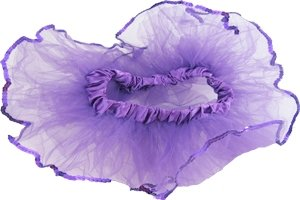

{'asin': '0000031887',
 'brand': 'Boutique Cutie',
 'categories': [['Clothing, Shoes & Jewelry',
                 'Girls',
                 'Clothing',
                 'Active',
                 'Active Skirts']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/314qZjYevsL.jpg',
 'price': 6.79,
 'salesRank': {'Sports &amp; Outdoors': 8547},
 'title': 'Ballet Dress-Up Fairy Tutu'}


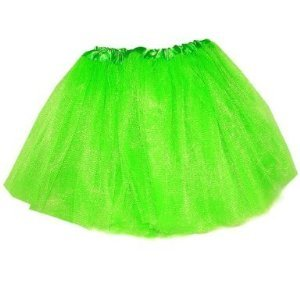

{'asin': '0123456479',
 'categories': [['Clothing, Shoes & Jewelry',
                 'Novelty, Costumes & More',
                 'Jewelry Accessories',
                 'Jewelry Boxes & Organizers',
                 'Jewelry Boxes']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/413tGhqoOTL._SY300_.jpg',
 'price': 64.98,
 'salesRank': {'Kitchen & Dining': 16987},
 'title': 'SHINING IMAGE HUGE PINK LEATHER JEWELRY BOX / CASE / STORAGE / '
          'ORGANIZER WITH TRAVEL CASE AND LOCK'}


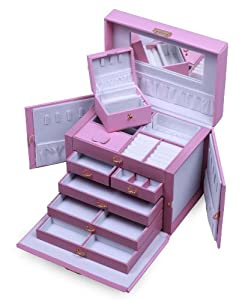

{'asin': '0456844570',
 'categories': [['Clothing, Shoes & Jewelry',
                 'Women',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses'],
                ['Clothing, Shoes & Jewelry',
                 'Novelty, Costumes & More',
                 'Band & Music Fan',
                 'Accessories']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/31QZTHxvqFL._SX342_.jpg',
 'salesRank': {'Clothing': 1180499},
 'title': "RiZ Women's Beautify Crafted &frac12; Rimmed Floral Clubmaster "
          'Sunglasses'}


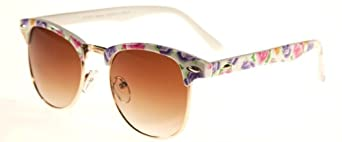

{'asin': '0456808574',
 'categories': [['Clothing, Shoes & Jewelry',
                 'Women',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses'],
                ['Clothing, Shoes & Jewelry',
                 'Men',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses'],
                ['Clothing, Shoes & Jewelry',
                 'Novelty, Costumes & More',
                 'Band & Music Fan',
                 'Accessories']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/31UsrgT51RL._SX342_.jpg',
 'salesRank': {'Clothing': 1038084},
 'title': 'Lantin White Visor Wrap Around Ski Style Aviator Sunglasses with '
          'Black Lenses'}


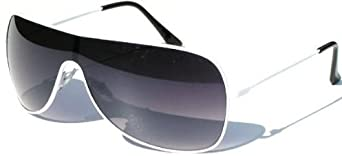

In [99]:
for p in islice(iter_products(fname_products), 5):
    pprint({k:v for (k,v) in p.items() if k not in {'related', 'description'}})
    display(Image(p['imUrl'], width=128, height=128))

Next we'll use the `iter_vectors` function to iterate over product IDs and image vectors. Each vector is just a list of 4096 floats, generated using a deep convolutional neural network.

There's not much value in inspecting the individual vectors, so we'll just show the vector length and first few values for each one. 

In [100]:
for (asin, vec) in islice(iter_vectors(fname_vectors), 3):
    print(asin, len(vec), vec[:5])

B000IG9NS6 4096 [0.0, 0.608299970626831, 0.0, 0.0, 0.0]
B000FIPV42 4096 [0.0, 0.0, 0.0, 0.0, 0.0]
B000FZ1AO0 4096 [0.4043000042438507, 0.0, 4.453100204467773, 0.0, 0.0]


Let's sample a subset of vectors and plot the distribution of values. This type of aggregate view is more informative than inspecting individual vectors.

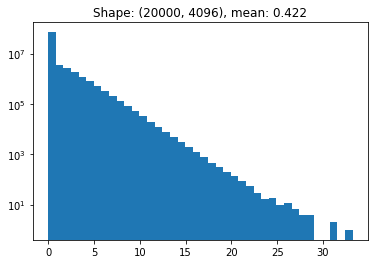

In [101]:
sample = np.array([v for (_, v) in islice(iter_vectors(fname_vectors), 20000)])
plt.title("Shape: %s, mean: %.3f" % (sample.shape, sample.mean()))
plt.hist(np.ravel(sample), bins=40, log=True)
plt.show()

The histogram above shows there are many zeros in the vectors. 

The zeros usually don't add much information when computing vector similarities. (Forgive my mathematical hand-waviness.) At the same time, the zeros occupy storage space on disk, space in memory, and CPU time when computing similarities. We should be able to reduce the dimensionality while preserving most of the information.

I included a simple dimensionality reduction technique in the function `iter_vectors_reduced`. It takes the file name, the desired `dims`, and a number of `samples`. It iterates over the first `samples` vectors in the given file name, maintaining a sum along each index. It then computes the `dims` indices with the largest sums. It returns anoter generator which will iterate over the vectors in a given file name and return only the greatest indices based on the original sample.

Let's reduce the dimensionality from 4096 to 128 and inspect the results.

B000IG9NS6 128 [5.9893999099731445, 0.0, 3.8183999061584473, 2.5580999851226807, 1.5513999462127686]
B000FIPV42 128 [4.293399810791016, 0.0, 3.595599889755249, 0.0, 0.0]
B000FZ1AO0 128 [2.1886000633239746, 1.9733999967575073, 12.249600410461426, 4.564300060272217, 7.321000099182129]


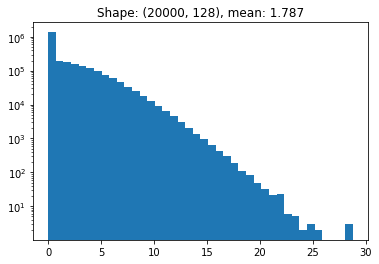

In [104]:
reduced = iter_vectors_reduced(fname_vectors, dims=128, samples=10000)

for (asin, vec) in islice(reduced(fname_vectors), 3):
    print(asin, len(vec), vec[:5])

sample = np.array([v for (_, v) in islice(reduced(fname_vectors), 20000)])
plt.title("Shape: %s, mean: %.3f" % (sample.shape, sample.mean()))
plt.hist(np.ravel(sample), bins=40, log=True)
plt.show()

Now we have a full order of magnitude fewer zeros and only need to store and compute similarities for 128 dimensions instead of 4096.

## Connect to Elasticsearch

In [243]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk

es = Elasticsearch(["http://localhost:9200"])
es.cluster.health(wait_for_status='yellow', request_timeout=1)

{'cluster_name': 'docker-cluster',
 'status': 'green',
 'timed_out': False,
 'number_of_nodes': 2,
 'number_of_data_nodes': 1,
 'active_primary_shards': 1,
 'active_shards': 1,
 'relocating_shards': 0,
 'initializing_shards': 0,
 'unassigned_shards': 0,
 'delayed_unassigned_shards': 0,
 'number_of_pending_tasks': 0,
 'number_of_in_flight_fetch': 0,
 'task_max_waiting_in_queue_millis': 0,
 'active_shards_percent_as_number': 100.0}

## Create the Elasticsearch Index

Now we have an idea of the shape of our dataset: each product has a dictionary of metadata and an image vector.

Let's create an index and define a mapping that represents the shape of our data.
The mapping has the following properties:

|property|type|description|
|:--|:--|:--|
|asin|keyword|Unique product identifier.|
|imVecElastiknn|elastiknn_dense_float_vector|The image vector, stored using Elastiknn. We'll also use the Angular LSH model settings to support approximate queries.|
|imVecXpack|dense_vector|The image vector, stored using the X-Pack dense_vector data type.|
|title|text||
|description|text||
|price|float||

Note that we're including two vectors: one using the `dense_vector` datatype that comes with Elasticsearch, the other using the `elastiknn_dense_float_vector` datatype provided by Elastiknn. We're including both so we can compare functionality and performance.

In [106]:
index = 'amazon-products'

if es.indices.exists(index):
    es.indices.delete(index)

es.indices.create(index, {
    "settings": {
        "elastiknn": True,
        "number_of_shards": 1,
        "number_of_replicas": 0
    }
})

mapping = {
    "properties": {
        "asin": { "type": "keyword" },
        "imVecElastiknn": {
            "type": "elastiknn_dense_float_vector",
            "elastiknn": {
                "dims": 128,
                "model": "lsh",
                "similarity": "angular",
                "L": 50,
                "k": 2
            }
        },
        "imVecXpack": {
            "type": "dense_vector",
            "dims": 128
        },
        "title": { "type": "text" },
        "description": { "type": "text" },
        "price": { "type": "float" },
        "imUrl": { "type": "text" }
    }
}
es.indices.put_mapping(mapping, index)

es.indices.get_mapping(index)

{'amazon-products': {'mappings': {'properties': {'asin': {'type': 'keyword'},
    'description': {'type': 'text'},
    'imUrl': {'type': 'text'},
    'imVecElastiknn': {'type': 'elastiknn_dense_float_vector',
     'elastiknn': {'model': 'lsh',
      'similarity': 'angular',
      'dims': 128,
      'L': 50,
      'k': 2}},
    'imVecXpack': {'type': 'dense_vector', 'dims': 128},
    'price': {'type': 'float'},
    'title': {'type': 'text'}}}}}

## Index the Products

Now that we've created a new index and told Elasticsearch the shape of our data, we'll index (i.e. store) the data.

We'll first iterate over the product data, using the `asin` as the document ID and storing everything except the `imVec` properties. We'll iterate over the vectors separately to populate them.

There are about 1.5M products, and the indexing takes about 4 minutes on my laptop.

In [107]:
def product_actions():
    for p in tqdm(iter_products(fname_products)):
        yield { 
            "_op_type": "index", "_index": index, "_id": p["asin"], 
            "asin": p["asin"], "title": p.get("title", None), 
            "description": p.get("description", None),
            "price": p.get("price", None),
            "imUrl": p.get("imUrl", None)
        }

bulk(es, product_actions(), chunk_size=1000, max_retries=2)

1503384it [03:59, 6281.99it/s]


(1503384, [])

Indexing the vectors is slower, about 25 minutes for 1.5M vectors.

In [149]:
reduced = iter_vectors_reduced(fname_vectors, 128, 10000)

def vector_actions():
    for (asin, v) in tqdm(reduced(fname_vectors)):
        yield { "_op_type": "update", "_index": index, "_id": asin, 
                "doc": { "imVecElastiknn": { "values": v }, "imVecXpack": v }}

bulk(es, vector_actions(), chunk_size=100, max_retries=2)

1494171it [24:44, 1006.62it/s]


(1494171, [])

## Run Standard Queries

Start by matching a simple keyword query: _**timex men's wrist watch**_

Found 10000 hits in 10 ms

Title:          Timex Men's Sl Series Automatic T2n290 Wrist Watch
Description:    None...
Price:          149.95
ID:             B00BBTCG9C
Score:          37.13423


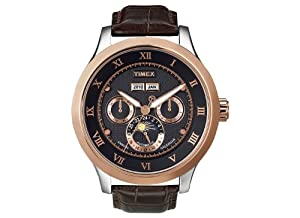


Title:          2001 Timex Copration Timex Wrist Rave Rock Beats And Fun Games Interactive LCD Watch
Description:    None...
Price:          None
ID:             B00016LA4S
Score:          30.718153


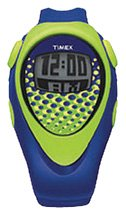


Title:          Timex Men's Watch T66801
Description:    None...
Price:          None
ID:             B0000U0LRC
Score:          29.325327


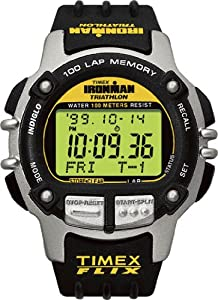


Title:          Timex Men's Watch T2G831
Description:    None...
Price:          None
ID:             B000CBUH2S
Score:          29.325327


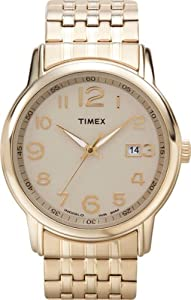


Title:          Timex Men's T71542 Watch
Description:    None...
Price:          None
ID:             B0009Y6F3I
Score:          29.325327


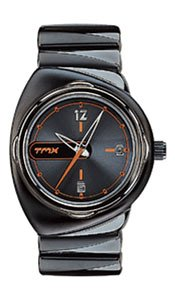

In [225]:
body = {
    "query": {
        "multi_match": {
            "query": "timex men's wrist watch",
            "fields": ["title^2", "description"]
        }
    }
}

res = es.search(index=index, body=body, size=5)
display_hits(res)

## Exhaustive query for similar images using built-in Elasticsearch functionality

Let's say you really like the fifth result (ID `B0009Y6F3I`) and want to find some similar-looking watches.

We'll start by using the built-in Elasticsearch functionality to do an exhaustive similarity query on the whole index. This will consist of three steps:

1. Fetch the vector for this product.
2. Use it to construct a script-score query.
3. Execute the query. This computes the `cosineSimilarity` between the given vector and all ~1.5M vectors in the index.

The query finds some compelling results.

Found 10000 hits in 370 ms

Title:          Timex Men's T71542 Watch
Description:    None...
Price:          None
ID:             None
Score:          2.0


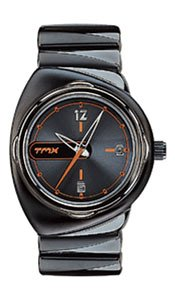


Title:          Timex Men's T71532 Watch
Description:    None...
Price:          None
ID:             None
Score:          1.8268907


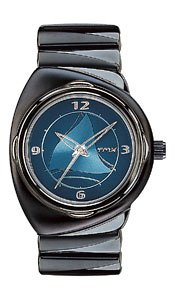


Title:          Fruitz NECTARINE Ladies Watch F36S-N-PR
Description:    None...
Price:          None
ID:             None
Score:          1.8196744


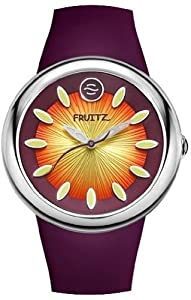


Title:          kujj AT5057BLK Men's Silver Tone Sports Analog Watch
Description:    None...
Price:          None
ID:             None
Score:          1.8128703


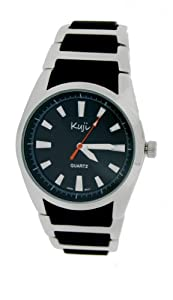


Title:          Skagen Titanium Women's Quartz Watch 530LTMN
Description:    None...
Price:          None
ID:             None
Score:          1.8114427


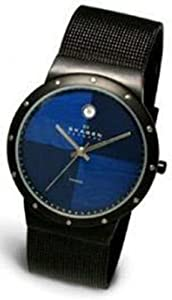

In [297]:
product_id = "B0009Y6F3I"

fetch_res = es.get(index=index, id=product_id)
query_vec = fetch_res['_source']['imVecXpack']

body = {
    "query": {
        "script_score": {
            "query": { "match_all": {} },
            "script": {
                "source": 'doc["imVecXpack"].size() == 0 ? 0 : 1.0 + cosineSimilarity(params.vec, "imVecXpack")',
                "params": {
                    "vec": query_vec
                }
            }
        }
    }
}

res = es.search(index=index, body=body, size=5, _source=['title', 'description', 'id', 'imUrl'])
display_hits(res)

## Exhaustive query for similar images using Elastiknn

Let's implement the same query using Elastiknn. There are two main differences compared to the previous query:

1. We reference the query vector using its ID, thus avoiding a round trip request to fetch the vector.
2. We don't need to use a script. The whole query is simple JSON keys and values.

Found 10000 hits in 513 ms

Title:          Timex Men's T71542 Watch
Description:    None...
Price:          None
ID:             None
Score:          2.0


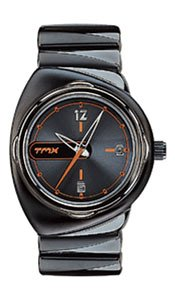


Title:          Timex Men's T71532 Watch
Description:    None...
Price:          None
ID:             None
Score:          1.8268907


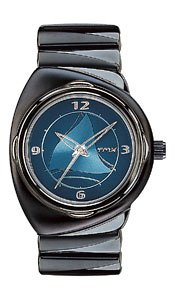


Title:          Fruitz NECTARINE Ladies Watch F36S-N-PR
Description:    None...
Price:          None
ID:             None
Score:          1.8196745


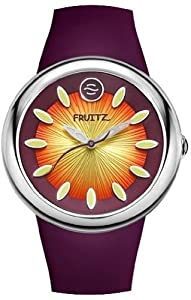


Title:          kujj AT5057BLK Men's Silver Tone Sports Analog Watch
Description:    None...
Price:          None
ID:             None
Score:          1.8128701


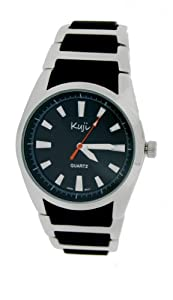


Title:          Skagen Titanium Women's Quartz Watch 530LTMN
Description:    None...
Price:          None
ID:             None
Score:          1.8114427


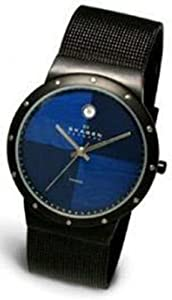

In [272]:
body = {
    "query": {
        "elastiknn_nearest_neighbors": {
            "vec": {
                "index": index,
                "field": "imVecElastiknn",
                "id": product_id
            },
            "field": "imVecElastiknn",
            "model": "exact",
            "similarity": "angular"
        }
    }
}

res = es.search(index=index, body=body, size=5, _source=['title', 'description', 'id', 'imUrl'])
display_hits(res)

## Approximate query for similar images using Elastiknn

Found 2250 hits in 200 ms

Title:          Timex Men's T71542 Watch
Description:    None...
Price:          None
ID:             None
Score:          2.0


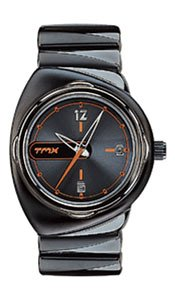


Title:          Timex Men's T71532 Watch
Description:    None...
Price:          None
ID:             None
Score:          1.8268907


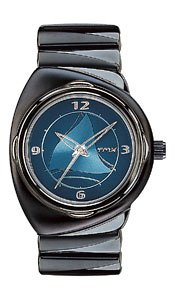


Title:          Fruitz NECTARINE Ladies Watch F36S-N-PR
Description:    None...
Price:          None
ID:             None
Score:          1.8196745


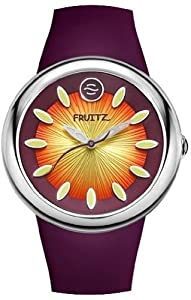


Title:          Rado D-Star Mens R15760112 Automatic
Description:    None...
Price:          None
ID:             None
Score:          1.7934548


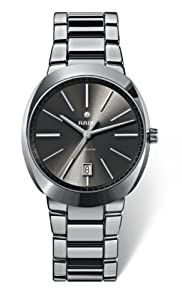


Title:          Certina Men's Watches DS 1 C006.407.16.051.00 - 2
Description:    None...
Price:          None
ID:             None
Score:          1.7924666


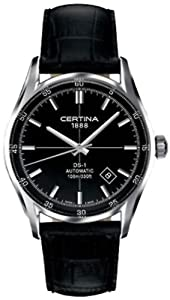

In [273]:
body = {
    "query": {
        "elastiknn_nearest_neighbors": {
            "vec": {
                "index": index,
                "field": "imVecElastiknn",
                "id": product_id
            },
            "field": "imVecElastiknn",
            "model": "lsh",
            "similarity": "angular",
            "candidates": 75
        }
    }
}

res = es.search(index=index, body=body, size=5, _source=['title', 'description', 'id', 'imUrl'])
display_hits(res)

## Combine Keyword and Image Similarity Queries

Found 10000 hits in 82 ms

Title:          Timex Men's T71542 Watch
Description:    None...
Price:          None
ID:             None
Score:          2.0


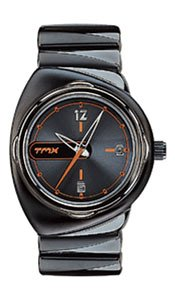


Title:          Timex Men's T71532 Watch
Description:    None...
Price:          None
ID:             None
Score:          1.8268907


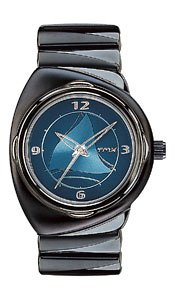


Title:          kujj AT5057BLK Men's Silver Tone Sports Analog Watch
Description:    None...
Price:          None
ID:             None
Score:          1.8128703


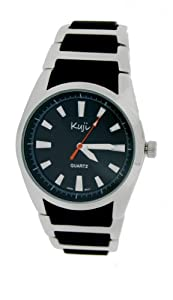


Title:          Revue Thommen Men's 21010.2137 Heritage Mens Black Face Automatic Watch Watch
Description:    None...
Price:          None
ID:             None
Score:          1.8064389


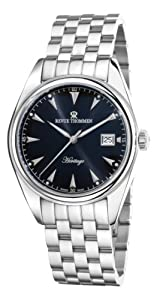


Title:          Police Men's PL-12744JSBS/04M Horizon Silver Dial Black Steel Watch
Description:    None...
Price:          None
ID:             None
Score:          1.80114


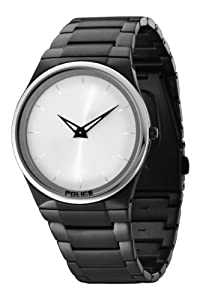

In [296]:
body = {
    "query": {
        "multi_match": {
            "query": "men's",
            "fields": ["title^2", "description"]
        }
    },
    "rescore": {
        "window_size": 1000,
        "query": { 
            "rescore_query": {
                "elastiknn_nearest_neighbors": {
                    "vec": {
                        "index": index,
                        "field": "imVecElastiknn",
                        "id": product_id
                    },
                    "field": "imVecElastiknn",
                    "model": "lsh",
                    "similarity": "angular",
                    "candidates": 75
                }
            },
            "query_weight": 0,
            "rescore_query_weight": 1
        }
    }
}

body = {
  "query": {
    "multi_match": {
        "query": "men",
        "fields": ["title^2", "description"]
    }
  },
  "rescore": {
    "window_size": 10,
    "query": {
      "rescore_query": {
        "elastiknn_nearest_neighbors": {
            "field" : "vec",
            "similarity" : "angular",
            "model" : "exact",            
            "vec" : {
                "index": index,
                "field": "imVecElastiknn",
                "id": product_id
            }
        }
      },
      "query_weight": 0,
      "rescore_query_weight": 1
    }
  }
}

body = {
    "query": {
        "script_score": {
            "query": {
                "multi_match": {
                    "query": "men's",
                    "fields": ["title^2", "description"]
                }
            },
            "script": {
                "source": 'doc["imVecXpack"].size() == 0 ? 0 : 1.0 + cosineSimilarity(params.vec, "imVecXpack")',
                "params": {
                    "vec": query_vec
                }
            }
        }
    }
}
res = es.search(index=index, body=body, size=5, _source=['title', 'description', 'id', 'imUrl'])
display_hits(res)

## Improve Performance by Adding Shards